# A notebook on clustering images by similarity

Using a day from 2023.      
-Generate embeddings for all images    
-K-means cluster      
-Assign labels to clusters    
-Get in there and analyze the clusters      


In [1]:
#Imports & Setup
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
from PIL import Image
import glob
import time
from tqdm import tqdm
import pickle

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


The first encoder that we are going to try with is the SAM2 encoder. 

In [2]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/opt/sam2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [3]:
#Load the files
image_path_list = glob.glob('/work/20230816_r_ios/*/*.jpg')
image_list = [cv2.resize(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), (512, 512)) for image_path in image_path_list]

In [4]:
embeddings_file = 'embeddings.pkl'
if os.path.exists(embeddings_file):
    with open(embeddings_file, 'rb') as f:
        all_embeddings = pickle.load(f)
else:
    all_embeddings = []
    start = time.time()
    batch_size = 10
    for i in tqdm(range(0, len(image_list), batch_size), desc="Processing images"):
        predictor.set_image_batch(image_list[i:i+batch_size])
        list_of_embeddings = predictor.get_image_embedding()
        list_embedding_reshaped = list_of_embeddings[:].view(list_of_embeddings[:].size(0), -1)
        all_embeddings.append(list_embedding_reshaped.cpu())
    with open('embeddings.pkl', 'wb') as file:
        pickle.dump(all_embeddings, file)
    end = time.time()
    print(f"Generating and storing embeddings took: {(end-start):.2f} sec")

Processing images: 100%|██████████████████████████████████████████████████████████| 189/189 [10:10<00:00,  3.23s/it]


Generating and storing embeddings took: 618.29 sec


In [5]:
print(len(all_embeddings))

189


In [6]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 43.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 20.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 14.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [7]:
from sklearn.cluster import KMeans
all_embeddings_flattened = [embedding.view(embedding.size(0), -1) for embedding in all_embeddings]
all_embeddings_np = np.vstack([embedding.numpy() for embedding in all_embeddings_flattened])
# Number of clusters
n_clusters = 2

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(all_embeddings_np)

# Print the cluster labels
print(clusters) 

[0 1 0 ... 0 0 0]


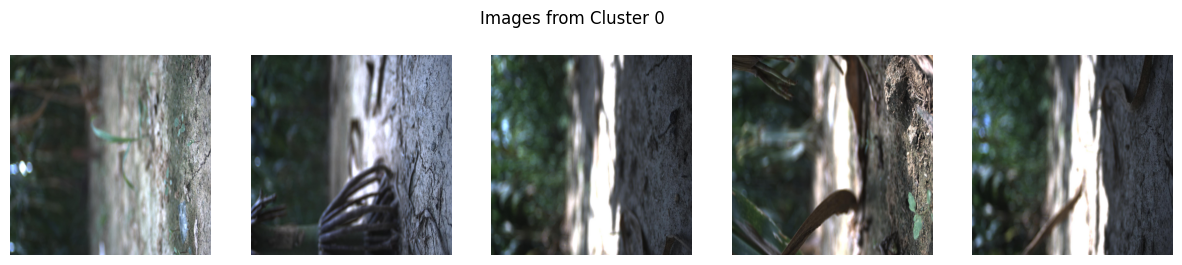

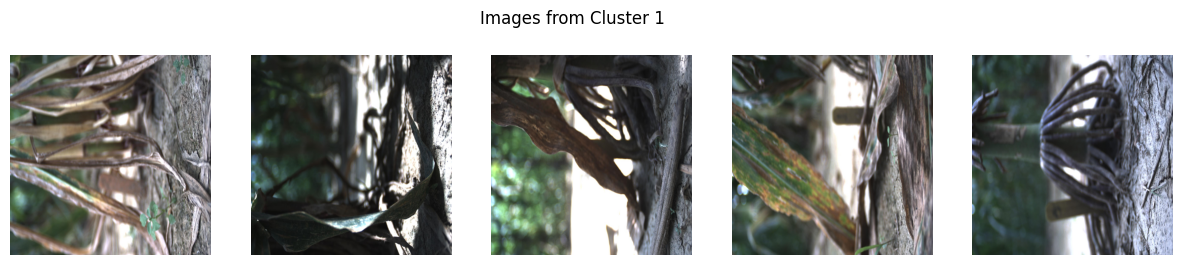

In [8]:
# Get the indices of the images in each cluster
cluster_0_indices = [i for i, cluster in enumerate(clusters) if cluster == 0]
cluster_1_indices = [i for i, cluster in enumerate(clusters) if cluster == 1]

# Display 5 images from cluster 0
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, index in enumerate(cluster_0_indices[50:55]):
    axes[i].imshow(image_list[index])
    axes[i].axis('off')
plt.suptitle('Images from Cluster 0')
plt.show()

# Display 5 images from cluster 1
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, index in enumerate(cluster_1_indices[:5]):
    axes[i].imshow(image_list[index])
    axes[i].axis('off')
plt.suptitle('Images from Cluster 1')
plt.show()

In [9]:
print(all_embeddings_np.shape)
#print the index of image_path_list that matches /work/20230816_r_ios/20230816_r_ios_/20230816_193353/351.jpg 
print(image_path_list.index('/work/20230816_r_ios/20230816_193353/351.jpg'))
# print(image_path_list[0])
print(cluster_0_indices[50])

(1886, 1048576)
1654
84


In [10]:
# def normalize(vec: np.ndarray):
#     return vec / np.linalg.norm(vec, axis=1, keepdims=True)
def normalize(vec: np.ndarray):
    if vec.ndim == 1:
        return vec / np.linalg.norm(vec)
    return vec / np.linalg.norm(vec, axis=1, keepdims=True)
all_embeddings_np_norm = [normalize(emb) for emb in all_embeddings_np]
#manually select a good and bad sample from the list
good_sample = all_embeddings_np_norm[1654] #location of 20230816_193353/351.jpg 
bad_sample = all_embeddings_np_norm[84]


In [11]:
def extract_features(good,bad,big_list):
    ret = []
    for img_embedding in big_list:
        x = np.dot(good,img_embedding.T)
        y = np.dot(bad, img_embedding.T)
        ret.append((x,y))
    return ret

cos_similarity_space = extract_features(good_sample, bad_sample, all_embeddings_np_norm)


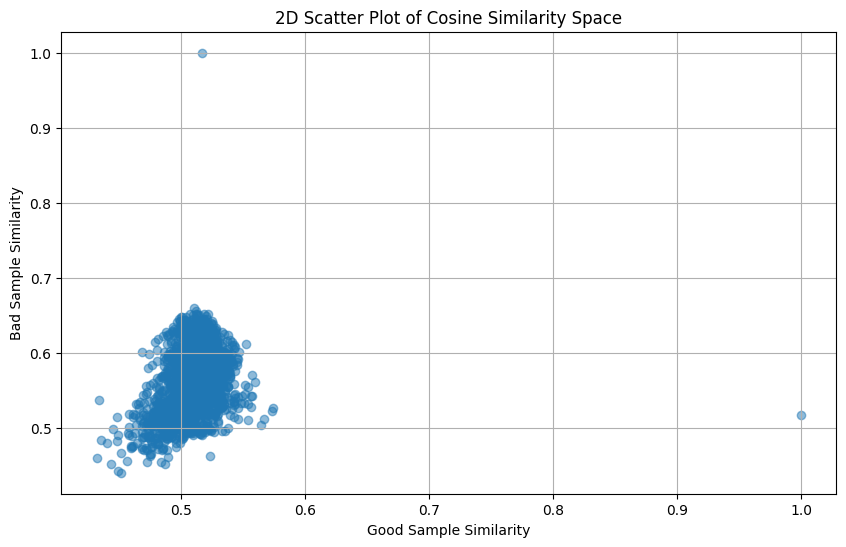

In [12]:
# Extract x and y coordinates from cos_similarity_space
x_coords = [x for x, y in cos_similarity_space]
y_coords = [y for x, y in cos_similarity_space]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_coords, y_coords, alpha=0.5)
plt.title('2D Scatter Plot of Cosine Similarity Space')
plt.xlabel('Good Sample Similarity')
plt.ylabel('Bad Sample Similarity')
plt.grid(True)
plt.show()

In [13]:
del all_embeddings_np_norm
del all_embeddings_flattened
del all_embeddings_np
del all_embeddings

In [14]:
flattened_image_1654 = normalize(image_list[1654].reshape(-1))
flattened_image_84 = normalize(image_list[84].reshape(-1))
flattened_normalized_image_list = [normalize(img.reshape(-1)) for img in image_list]

In [15]:
cos_similarity_space_rgb = extract_features(flattened_image_1654, flattened_image_84, flattened_normalized_image_list )

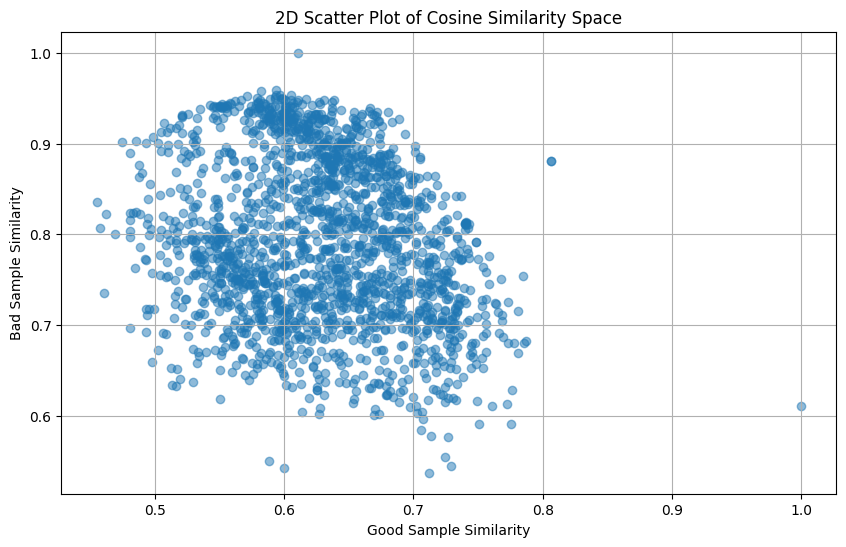

In [16]:
# Extract x and y coordinates from cos_similarity_space
x_coords = [x for x, y in cos_similarity_space_rgb]
y_coords = [y for x, y in cos_similarity_space_rgb]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_coords, y_coords, alpha=0.5)
plt.title('2D Scatter Plot of Cosine Similarity Space')
plt.xlabel('Good Sample Similarity')
plt.ylabel('Bad Sample Similarity')
plt.grid(True)
plt.show()

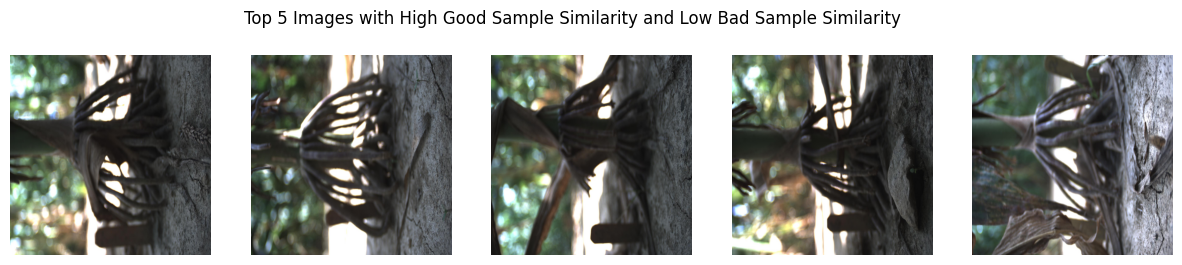

In [17]:
# Combine the indices with the similarity scores
indexed_cos_similarity_space = list(enumerate(cos_similarity_space))

# Sort by good sample similarity (descending) and bad sample similarity (ascending)
sorted_cos_similarity_space = sorted(indexed_cos_similarity_space, key=lambda x: (-x[1][0], x[1][1]))
# Filter sorted_cos_similarity_space for all entries where x[1][0] > x[1][1]
filtered_cos_sim_space = [x for x in sorted_cos_similarity_space if x[1][0] > x[1][1]]

# Select the top 5 images
# top_5_indices = [index for index, _ in sorted_cos_similarity_space[5:10]]
top_5_indices = [index for index, _ in filtered_cos_sim_space[:5]]
# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, index in enumerate(top_5_indices):
    axes[i].imshow(image_list[index])
    axes[i].axis('off')
plt.suptitle('Top 5 Images with High Good Sample Similarity and Low Bad Sample Similarity')
plt.show()

So here is the process that currently works...    
1) Get SAM2 image embeddings
2) Flatten embeddings
3) Normalize
4) Manually select a good image example and a bad image example. The good one should be an exemplary image and the bad one should be empty
5) Create an 2D projection with Cosine simmilarity to good image on the x-axis and Cosine similarity to the bad image on the y-axis
6) Sort based on the x axis, with y-axis as the tiebreaker
7) Filter out cases where x is greater than y (usually these are bad images)
